In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Tuple, List, Dict, Any
from pathlib import Path
import jax
import jax.numpy as jnp
from jax import random, Array
from tqdm.auto import tqdm
import equinox as eqx
from pprint import pprint
#set seeds
np.random.seed(42)
n_runs = 2000
n_exps = 500


In [31]:
df = pd.read_csv("data/japan_n_skorea.csv")

In [32]:
def save_fig(fig, name)-> None:
    """
    Save the figure to the specified path.
    
    :param name: A string representing the name of the figure.
    :param fig: A matplotlib figure object.
    :return: None
    """
    cwd = Path.cwd()
    path = cwd / "figures" / f"{name}.png"
    if not path.parent.exists(): path.parent.mkdir(parents=True)
    fig.savefig(path)
    
    

def time_difference(time: pd.Series) -> pd.Series:
    """
    Calculate the time difference between the current time and the next time.
    
    :param time: A pandas Series of datetime values.
    :return: A pandas Series of time differences.
    """
    time_diff = time - time.shift(1)
    return time_diff

def process_time(time: pd.Series) -> pd.Series:
    """
    Process the time series data by converting to datetime, sorting, and calculating time differences.
    
    :param time: A pandas Series of datetime values.
    :return: A pandas Series of time differences in seconds.
    """
    time = pd.to_datetime(time)
    time = time.sort_values()
    dt = time_difference(time)
    dt = dt.dt.total_seconds()
    dt = dt[dt > 0].reset_index(drop=True)
    return dt

def analyze_distributions(in_series: pd.Series, significance: float = 0.05) -> Tuple[List[List[Any]], Dict[str, Dict[str, float]]]:
    """
    Analyze the distribution of the data and test for goodness of fit.
    
    :param in_series: A pandas Series of time differences.
    :param significance: Significance level for the goodness of fit tests.
    :return: A tuple containing the results of the analysis and the output parameters.
    """
    results = []
    output_parameters = {}

    # Uniform distribution
    fit_uniform_dist = stats.uniform(loc=(in_series.min()), scale=in_series.max() - in_series.min())
    test = stats.kstest(in_series, fit_uniform_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Uniform Distribution", fit_status, p_value])
    output_parameters["Uniform Distribution"] = {
        "loc": in_series.min(),
        "scale": in_series.max() - in_series.min()
    }

    # Exponential distribution
    m1 = np.mean(in_series)
    fit_exponential_dist = stats.expon(scale=1 / m1)
    test = stats.kstest(in_series, fit_exponential_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Exponential Distribution", fit_status, p_value])
    output_parameters["Exponential Distribution"] = {
        "estimated_lambda": 1 / m1
    }

    # Gamma distribution
    m2 = np.mean([x ** 2 for x in in_series])
    est_beta = m1 / (m2 - m1 ** 2)
    est_alpha = m1 * est_beta
    fit_gamma_dist = stats.gamma(a=est_alpha, scale=1 / est_beta)
    test = stats.kstest(in_series, fit_gamma_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Gamma Distribution", fit_status, p_value])
    output_parameters["Gamma Distribution"] = {
        "estimated_alpha": est_alpha,
        "estimated_beta": est_beta
    }

    # Poisson distribution
    fi_poisson_dist = stats.poisson(mu=m1)
    test = stats.kstest(in_series, fi_poisson_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Poisson Distribution", fit_status, p_value])
    output_parameters["Poisson Distribution"] = {
        "estimated_lambda": m1
    }

    # Normal distribution
    estimated_std = m2 - m1 ** 2
    fit_normal_dist = stats.norm(loc=m1, scale=estimated_std)
    test = stats.kstest(in_series, fit_normal_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Normal Distribution", fit_status, np.format_float_scientific(test[1], precision=2)])
    output_parameters["Normal Distribution"] = {
        "estimated_mean": m1,
        "estimated_std": estimated_std
    }
    return results, output_parameters






def save_fig(fig, name) -> None:
    """
    Save the figure to the specified path.

    :param name: A string representing the name of the figure.
    :param fig: A matplotlib figure object.
    :return: None
    """
    cwd = Path.cwd()
    path = cwd / "figures" / f"{name}.png"
    if not path.parent.exists(): path.parent.mkdir(parents=True)
    fig.savefig(path)


def analyze_distributions(magnitude_series: pd.Series, significance_level: float = 0.05) -> Tuple[
    List[List[Any]], Dict[str, Dict[str, float]]]:
    """
    Analyze the distribution of the data and test for goodness of fit.

    :param magnitude_series: A pandas Series of earthquake magnitudes.
    :param significance_level: Significance level for the goodness of fit tests.
    :return: A tuple containing the results of the analysis and the output parameters.
    """
    results = []
    output_parameters = {}

    # Uniform distribution
    uniform_fit = stats.uniform(loc=(magnitude_series.min()), scale=magnitude_series.max() - magnitude_series.min())
    uniform_test = stats.kstest(magnitude_series, uniform_fit.cdf)
    uniform_p_value = uniform_test[1]
    uniform_fit_status = "Good fit" if uniform_p_value > significance_level else "Bad fit"
    results.append(["Uniform Distribution", uniform_fit_status, uniform_p_value])
    output_parameters["Uniform Distribution"] = {
        "loc": magnitude_series.min(),
        "scale": magnitude_series.max() - magnitude_series.min()
    }

    # Exponential distribution
    mean_magnitude = np.mean(magnitude_series)
    exponential_fit = stats.expon(scale=1 / mean_magnitude)
    exponential_test = stats.kstest(magnitude_series, exponential_fit.cdf)
    exponential_p_value = exponential_test[1]
    exponential_fit_status = "Good fit" if exponential_p_value > significance_level else "Bad fit"
    results.append(["Exponential Distribution", exponential_fit_status, exponential_p_value])
    output_parameters["Exponential Distribution"] = {
        "estimated_lambda": 1 / mean_magnitude
    }

    # Gamma distribution
    mean_square_magnitude = np.mean([x ** 2 for x in magnitude_series])
    estimated_beta = mean_magnitude / (mean_square_magnitude - mean_magnitude ** 2)
    estimated_alpha = mean_magnitude * estimated_beta
    gamma_fit = stats.gamma(a=estimated_alpha, scale=1 / estimated_beta)
    gamma_test = stats.kstest(magnitude_series, gamma_fit.cdf)
    gamma_p_value = gamma_test[1]
    gamma_fit_status = "Good fit" if gamma_p_value > significance_level else "Bad fit"
    results.append(["Gamma Distribution", gamma_fit_status, gamma_p_value])
    output_parameters["Gamma Distribution"] = {
        "estimated_alpha": estimated_alpha,
        "estimated_beta": estimated_beta
    }

    # Poisson distribution
    poisson_fit = stats.poisson(mu=mean_magnitude)
    poisson_test = stats.kstest(magnitude_series, poisson_fit.cdf)
    poisson_p_value = poisson_test[1]
    poisson_fit_status = "Good fit" if poisson_p_value > significance_level else "Bad fit"
    results.append(["Poisson Distribution", poisson_fit_status, poisson_p_value])
    output_parameters["Poisson Distribution"] = {
        "estimated_lambda": mean_magnitude
    }

    # Normal distribution
    estimated_std_dev = mean_square_magnitude - mean_magnitude ** 2
    normal_fit = stats.norm(loc=mean_magnitude, scale=estimated_std_dev)
    normal_test = stats.kstest(magnitude_series, normal_fit.cdf)
    normal_p_value = normal_test[1]
    normal_fit_status = "Good fit" if normal_p_value > significance_level else "Bad fit"
    results.append(["Normal Distribution", normal_fit_status, np.format_float_scientific(normal_test[1], precision=2)])
    output_parameters["Normal Distribution"] = {
        "estimated_mean": mean_magnitude,
        "estimated_std": estimated_std_dev
    }
    return results, output_parameters


def generate_qq_plot(in_series: pd.Series, output_parameters: Dict[str, Dict[str, float]], case: str,
                               title: str) -> None:
    """
    Generate a Q-Q plot of the data against the fitted distribution.
    :param in_series: input time series data
    :param output_parameters: parameters of the fitted distributions
    :param case: A string representing the case of earthquakes to analyze.
    :param title: A string representing the title of the plot.
    :return:
    """

    uniform_dist = stats.uniform(loc=output_parameters["Uniform Distribution"]["loc"],
                                 scale=output_parameters["Uniform Distribution"]["scale"])
    exp_dist = stats.expon(scale=1 / output_parameters["Exponential Distribution"]["estimated_lambda"])
    gamma_dist = stats.gamma(a=output_parameters["Gamma Distribution"]["estimated_alpha"],
                             scale=1 / output_parameters["Gamma Distribution"]["estimated_beta"])
    poisson_dist = stats.poisson(mu=output_parameters["Poisson Distribution"]["estimated_lambda"])
    normal_dist = stats.norm(loc=output_parameters["Normal Distribution"]["estimated_mean"],
                             scale=output_parameters["Normal Distribution"]["estimated_std"])

    distributions = [exp_dist, gamma_dist, normal_dist, poisson_dist, uniform_dist]
    names = ["Exponential", "Gamma", "Normal", "Poisson", "Uniform"]
    fig, ax = plt.subplots(nrows=len(distributions), ncols=1, figsize=(10, 5 * (len(distributions) + 1)))
    for i, dist in enumerate(distributions):
        stats.probplot(in_series, dist=dist, plot=ax[i])
        ax[i].set_title(f"Q-Q Plot of {names[i]}")
        ax[i].set_xlabel(f"Theoretical Quantiles ({names[i]})")
        ax[i].set_ylabel(f"Sample Quantiles")

    plt.suptitle(
        f"{title}",
        fontsize=16
    )
    save_fig(fig, f"qq_plot_{case}")
    plt.show()


def overlay_distribution_plot(in_series: pd.Series, output_parameters: Dict[str, Dict[str, float]], case: str,
                                        title: str) -> None:
    """
    Overlay the distribution plots of the fitted distributions and the data.

    :param in_series: A pandas Series of time differences.
    :param output_parameters: A dictionary of output parameters for the fitted distributions.
    :param case: A string representing the case of earthquakes to analyze.
    :param title: A string representing the title of the plot.
    :return: None
    """
    n = len(in_series)
    exp_dist = np.random.exponential(output_parameters["Exponential Distribution"]["estimated_lambda"], n)
    gamma_dist = np.random.gamma(output_parameters["Gamma Distribution"]["estimated_alpha"],
                                 1 / output_parameters["Gamma Distribution"]["estimated_beta"], n)
    normal_dist = np.random.normal(output_parameters["Normal Distribution"]["estimated_mean"],
                                   output_parameters["Normal Distribution"]["estimated_std"], n)
    poisson_dist = np.random.poisson(output_parameters["Poisson Distribution"]["estimated_lambda"], n)
    uniform_dist = np.random.uniform(output_parameters["Uniform Distribution"]["loc"],
                                     output_parameters["Uniform Distribution"]["scale"], n)

    distributions = [exp_dist, gamma_dist, normal_dist, poisson_dist, uniform_dist]
    names = ["Exponential", "Gamma", "Normal", "Poisson", "Uniform"]

    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10, 25))

    for i, dist in enumerate(distributions):
        sns.histplot(dist, kde=True, ax=ax[i])
        sns.histplot(in_series, kde=True, ax=ax[i])
        ax[i].legend(["Fitted Distribution", "Data"])
        ax[i].set_title(f"{names[i]} Distribution")
        ax[i].set_xlabel("Time Difference")
        ax[i].set_ylabel("Frequency")

    fig.suptitle(
        f"{title}",
        fontsize=16)

    save_fig(fig, f"overlay_magnitude_dist_{case}")
    plt.show()


def big_magnitude_probability(distribution_type: str, max_magnitude: float,
                              distribution_params: Dict[str, Dict[str, float]]) -> float:
    """
    Calculate the probability of a large earthquake occurring.

    :param distribution_type: Type of the distribution.
    :param max_magnitude: Maximum magnitude of the earthquake.
    :param distribution_params: A dictionary of output parameters for the fitted distributions.
    :return: Probability of a large earthquake occurring.
    """
    if distribution_type == "Uniform Distribution":
        return 1 - stats.uniform.cdf(max_magnitude, loc=distribution_params["Uniform Distribution"]["loc"],
                                     scale=distribution_params["Uniform Distribution"]["scale"])
    elif distribution_type == "Exponential Distribution":
        return 1 - stats.expon.cdf(max_magnitude,
                                   scale=1 / distribution_params["Exponential Distribution"]["estimated_lambda"])
    elif distribution_type == "Gamma Distribution":
        return 1 - stats.gamma.cdf(max_magnitude, a=distribution_params["Gamma Distribution"]["estimated_alpha"],
                                   scale=1 / distribution_params["Gamma Distribution"]["estimated_beta"])
    elif distribution_type == "Normal Distribution":
        return 1 - stats.norm.cdf(max_magnitude, loc=distribution_params["Normal Distribution"]["estimated_mean"],
                                  scale=distribution_params["Normal Distribution"]["estimated_std"])
    else:
        return -1


def magnitude_analysis(earthquake_data: pd.DataFrame, threshold_magnitude: float = 5) -> Tuple[str, Dict[str, float]]:
    """
     Analyze the magnitude data and determine the best fit distribution and the probability of a large earthquake.

     :param earthquake_data: A pandas DataFrame containing earthquake data.
     :param threshold_magnitude: The threshold magnitude to calculate the probability of a large earthquake.
     """
    results, distribution_params = analyze_distributions(earthquake_data["mag"])
    p_values = np.array([result[2] for result in results])

    best_fit_index = np.argmax(p_values)
    best_fit_distribution = results[best_fit_index]
    probability = big_magnitude_probability(best_fit_distribution[0], threshold_magnitude, distribution_params)

    print(
        f"The best fit distribution for the magnitude of the earthquakes is {best_fit_distribution[0]} with a p-value of {best_fit_distribution[2]}")
    print(f"The estimated parameters are: {distribution_params[best_fit_distribution[0]]}")
    print(f"The probability of a large earthquake occurring is {probability}")

    qq_mag_title = f"Q-Q Plot of Earthquake Magnitude vs Theoretical Distributions"
    ov_mag_title = f"Overlay of the Distribution Earthquake Magnitude with Theoretical Distributions  "
    generate_qq_plot(earthquake_data["mag"], distribution_params, "Magnitude", qq_mag_title)
    overlay_distribution_plot(earthquake_data["mag"], distribution_params, "Magnitude", ov_mag_title)

    return best_fit_distribution[0], distribution_params[best_fit_distribution[0]]




def main(data:pd.DataFrame, case:str) -> Tuple[List[List[Any]], Dict[str, Dict[str, float]]]:
    """
    Main function to process time series data, analyze distributions, and plot the results.
    
    :return: A tuple containing the results of the analysis and the output parameters.
    """
    cases = ["All", "Large", "Small"]
    assert case in cases, f"Invalid case. Choose from {cases}"
    
    time = None
    
    if case == "All":
        time = data["time"]
    elif case == "Large":
        time = data[data["mag"] > 5]["time"]
    elif case == "Small":
        time = data[data["mag"] < 5]["time"]
        

    dt = process_time(time)
    results, output_parameters = analyze_distributions(dt)
    overlay_distribution_plot(dt, output_parameters, case, f"Overlay of the Distribution of Time Differences with Theoretical Distributions ({case} Earthquakes)")
    generate_qq_plot(dt, output_parameters, case, f"Q-Q Plot of Time Differences vs Theoretical Distributions ({case} Earthquakes)")
    return results, output_parameters





In [33]:
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2024-09-24T06:00:53.328Z,31.3961,140.0063,62.992,4.6,mb,40.0,134.0,4.664,0.89,...,2024-09-24T06:34:59.040Z,"Izu Islands, Japan region",earthquake,11.04,8.591,0.105,27.0,reviewed,us,us
1,2024-09-23T23:14:19.526Z,31.5463,140.0638,11.710,5.6,mww,110.0,86.0,1.579,1.07,...,2024-09-24T13:57:02.040Z,"Izu Islands, Japan region",earthquake,7.31,4.231,0.053,34.0,reviewed,us,us
2,2024-09-21T15:57:50.402Z,31.1565,140.9208,40.337,4.4,mb,67.0,132.0,2.167,0.54,...,2024-09-21T18:51:42.040Z,"Izu Islands, Japan region",earthquake,5.78,7.628,0.076,51.0,reviewed,us,us
3,2024-09-20T12:22:20.539Z,33.2622,132.2763,50.692,4.9,mb,75.0,56.0,1.416,0.92,...,2024-09-21T04:48:46.731Z,"26 km SW of Yawatahama, Japan",earthquake,5.90,6.386,0.038,225.0,reviewed,us,us
4,2024-09-19T09:18:10.282Z,35.6655,140.9251,43.764,4.6,mb,37.0,119.0,2.367,1.65,...,2024-09-19T11:13:06.040Z,"11 km SE of Hasaki, Japan",earthquake,7.18,7.662,0.105,27.0,reviewed,us,us


# Hypothesis Testing

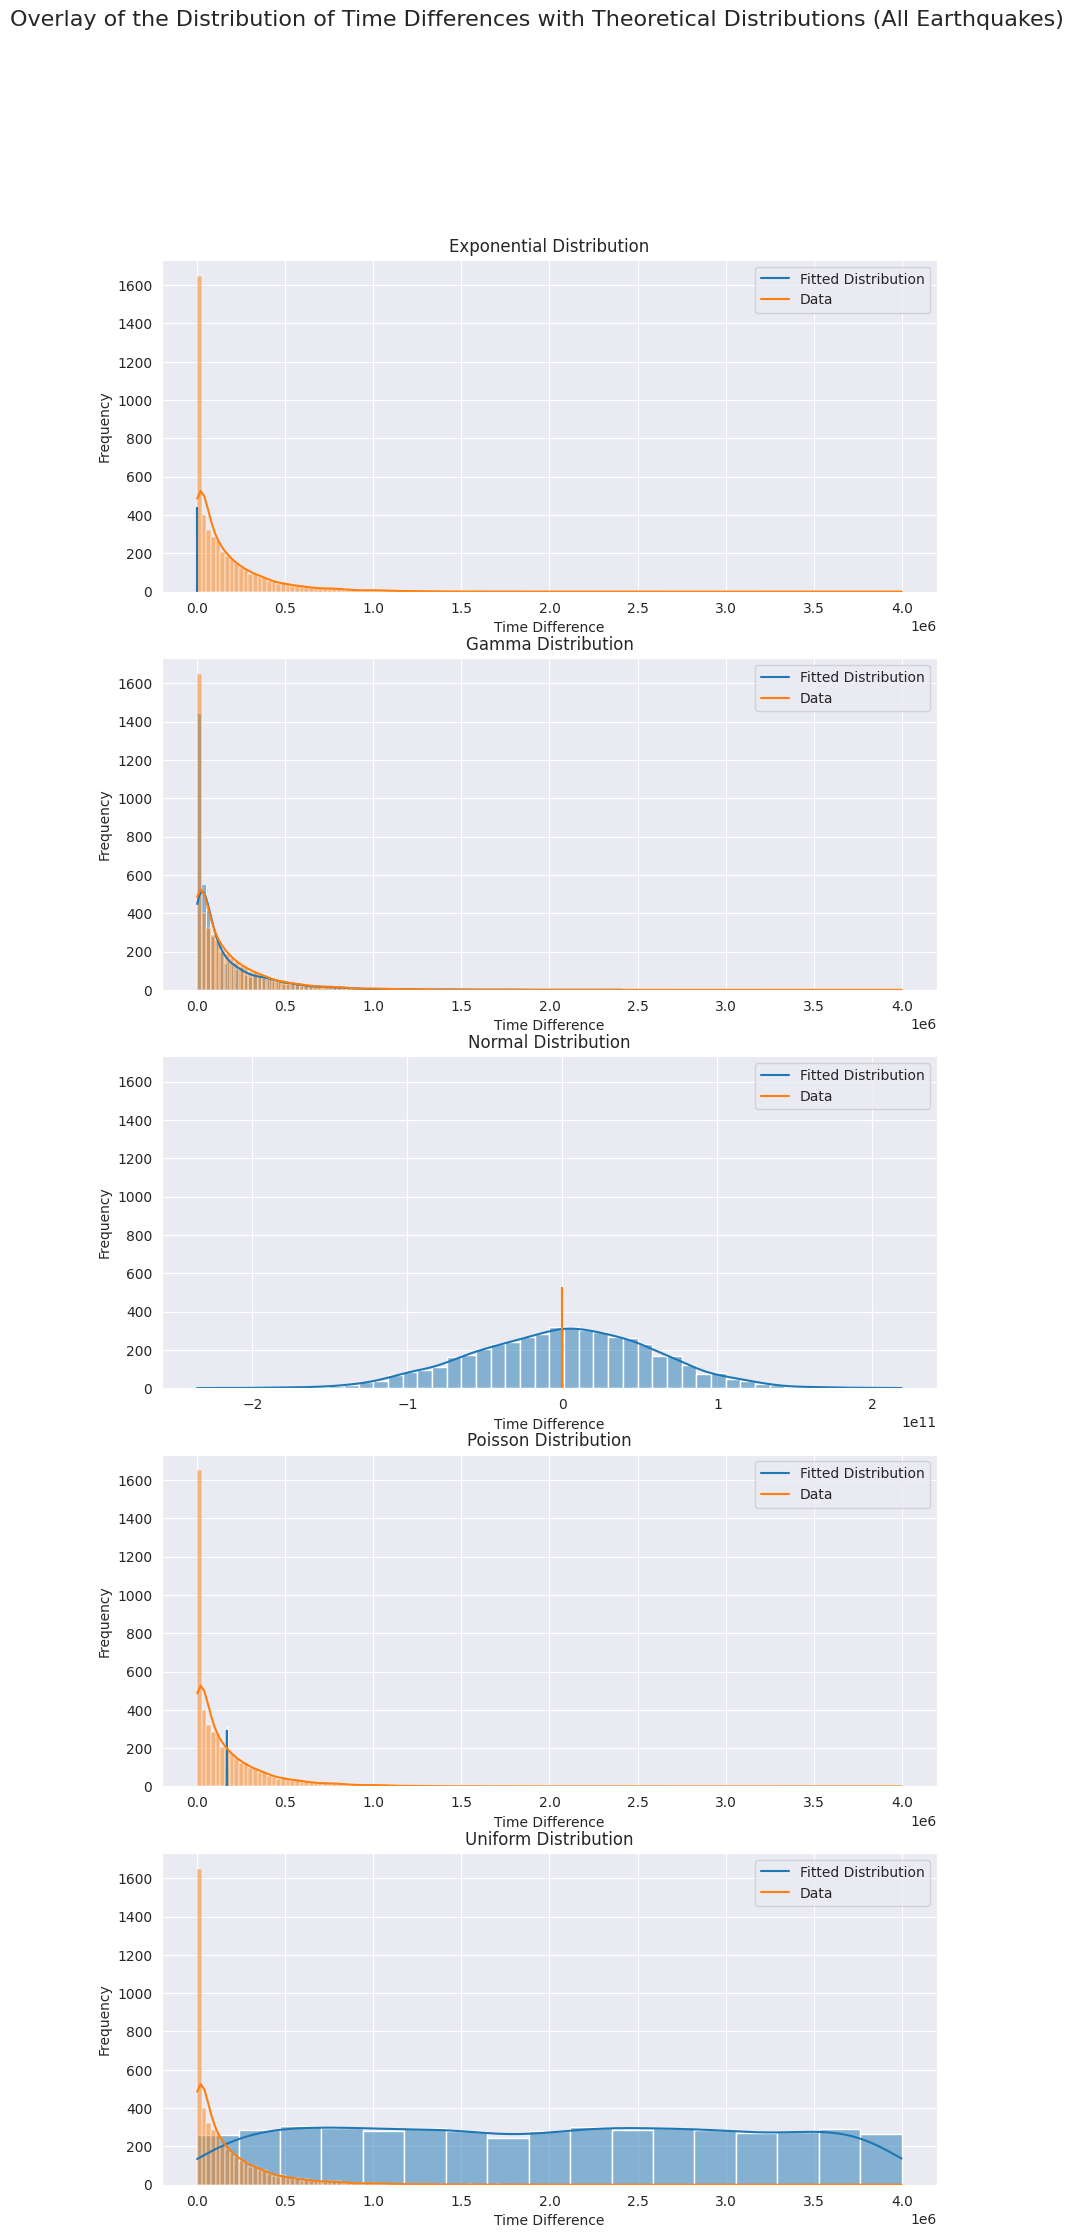

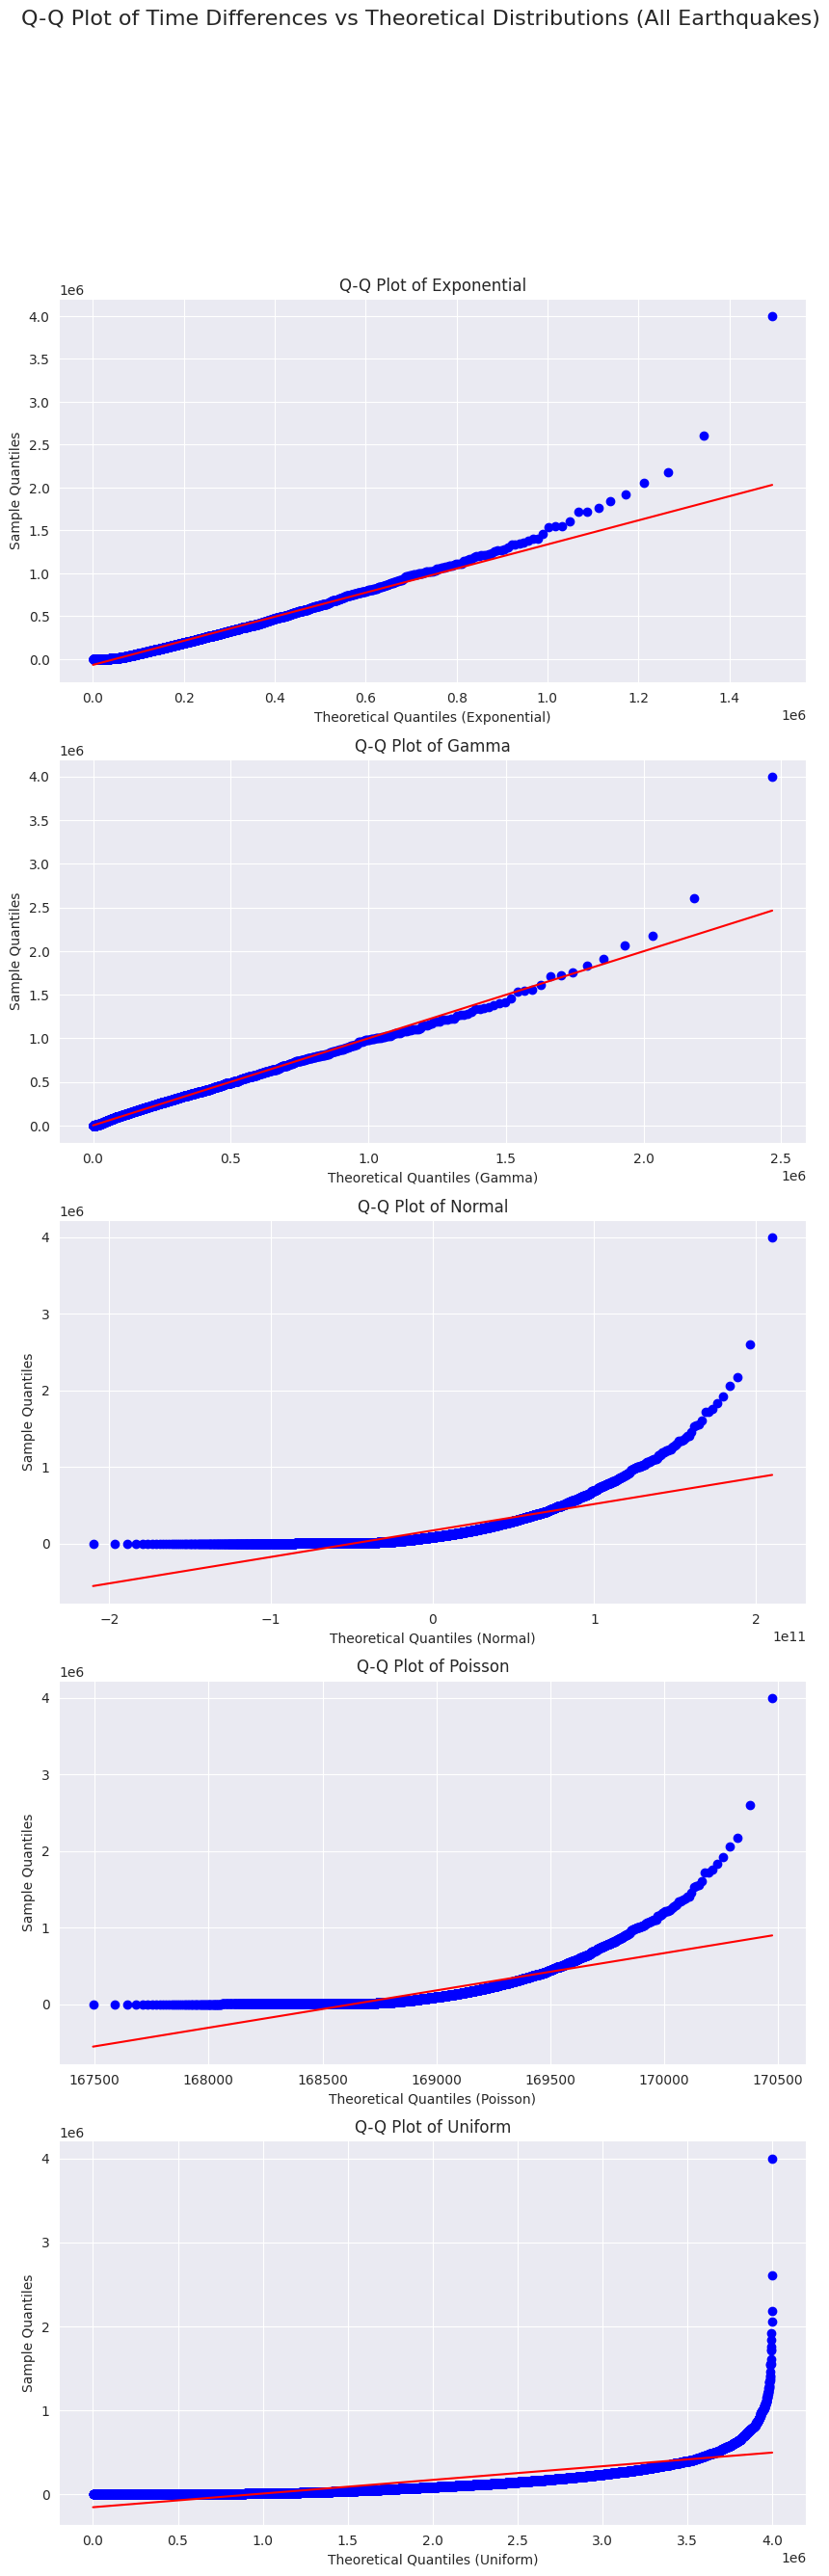

In [34]:

# all earthquake
results_all_eq, params_all_eq = main(df, "All")




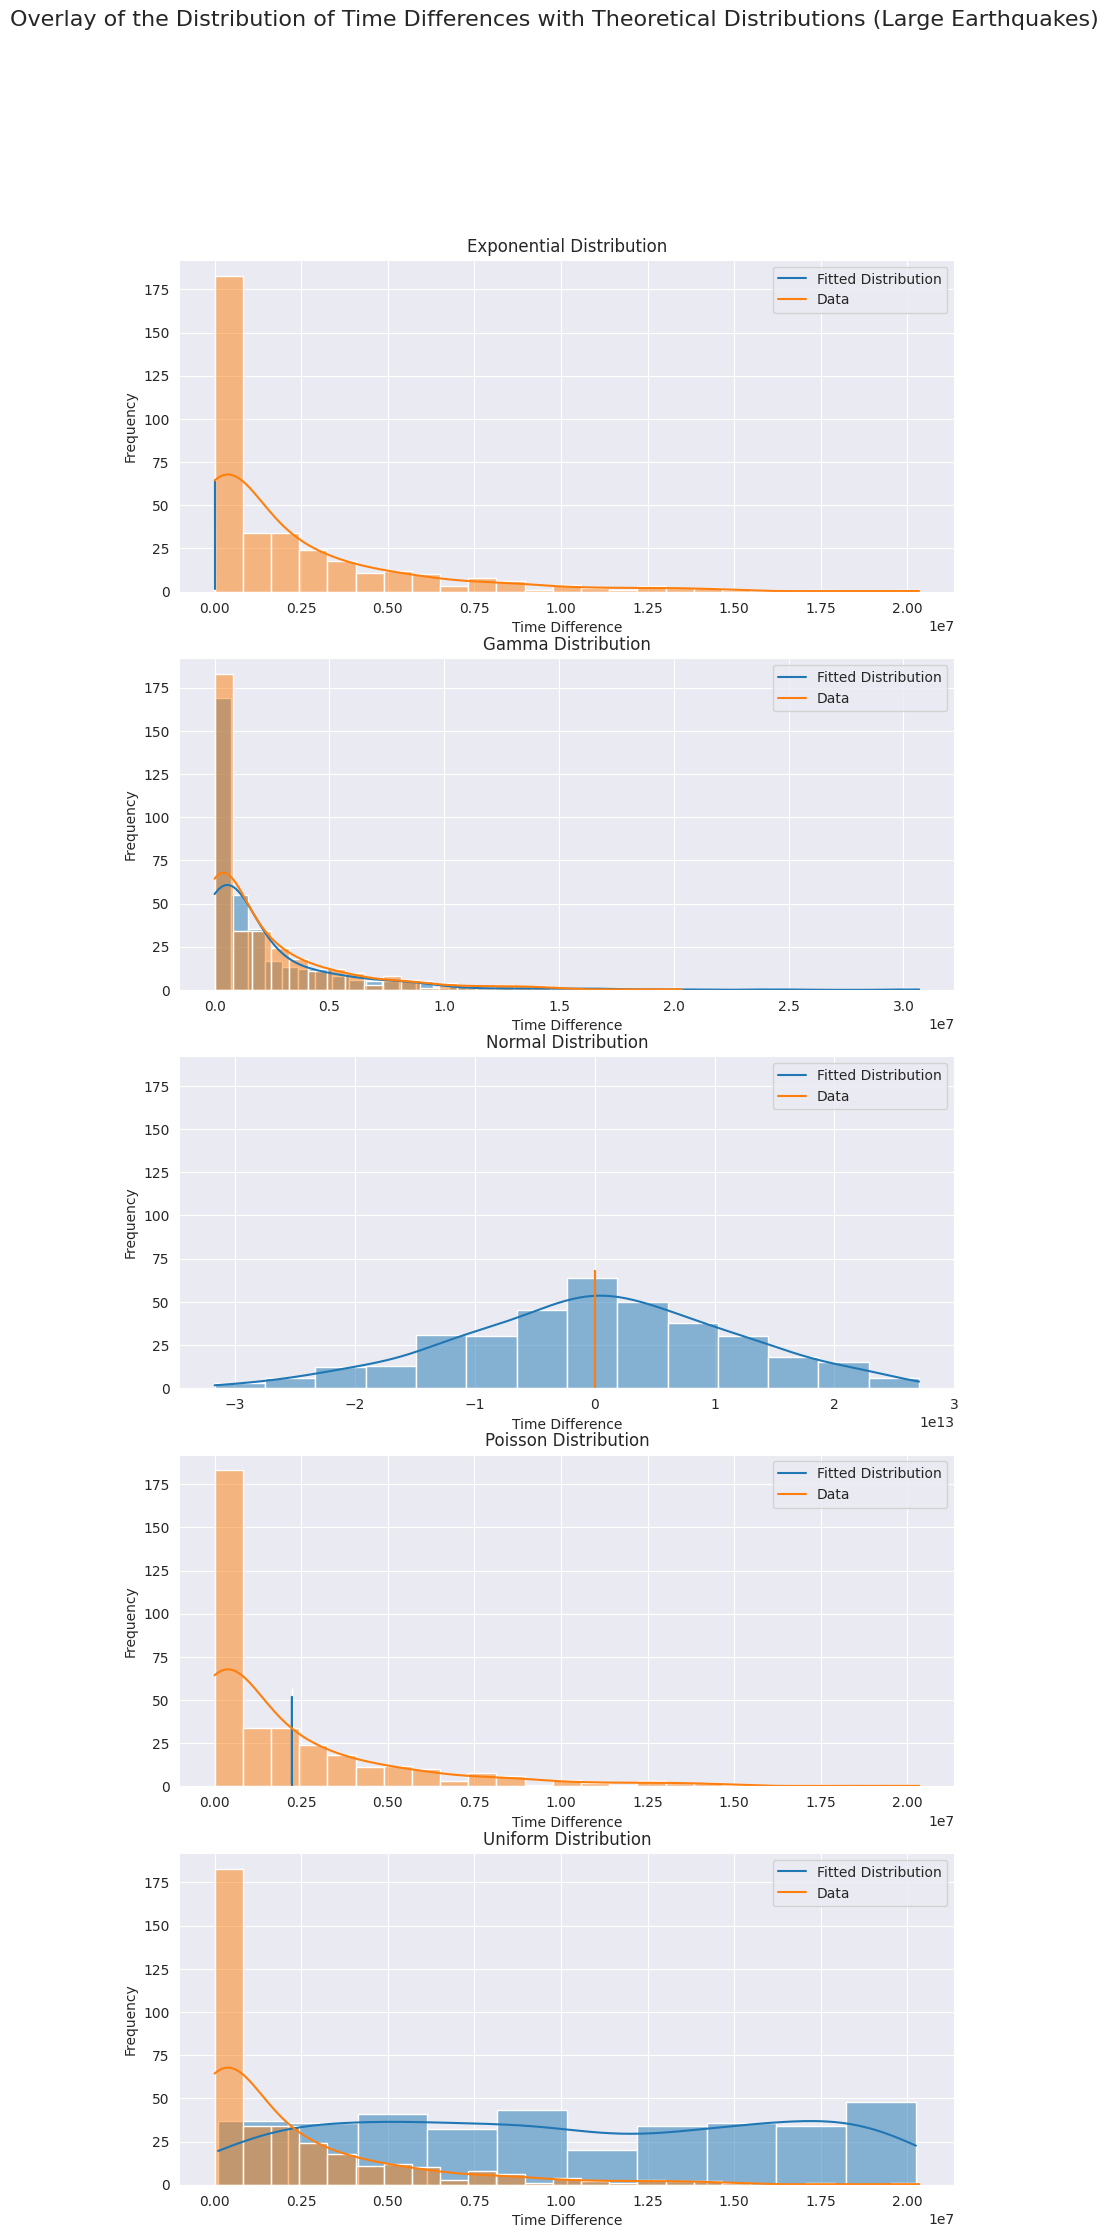

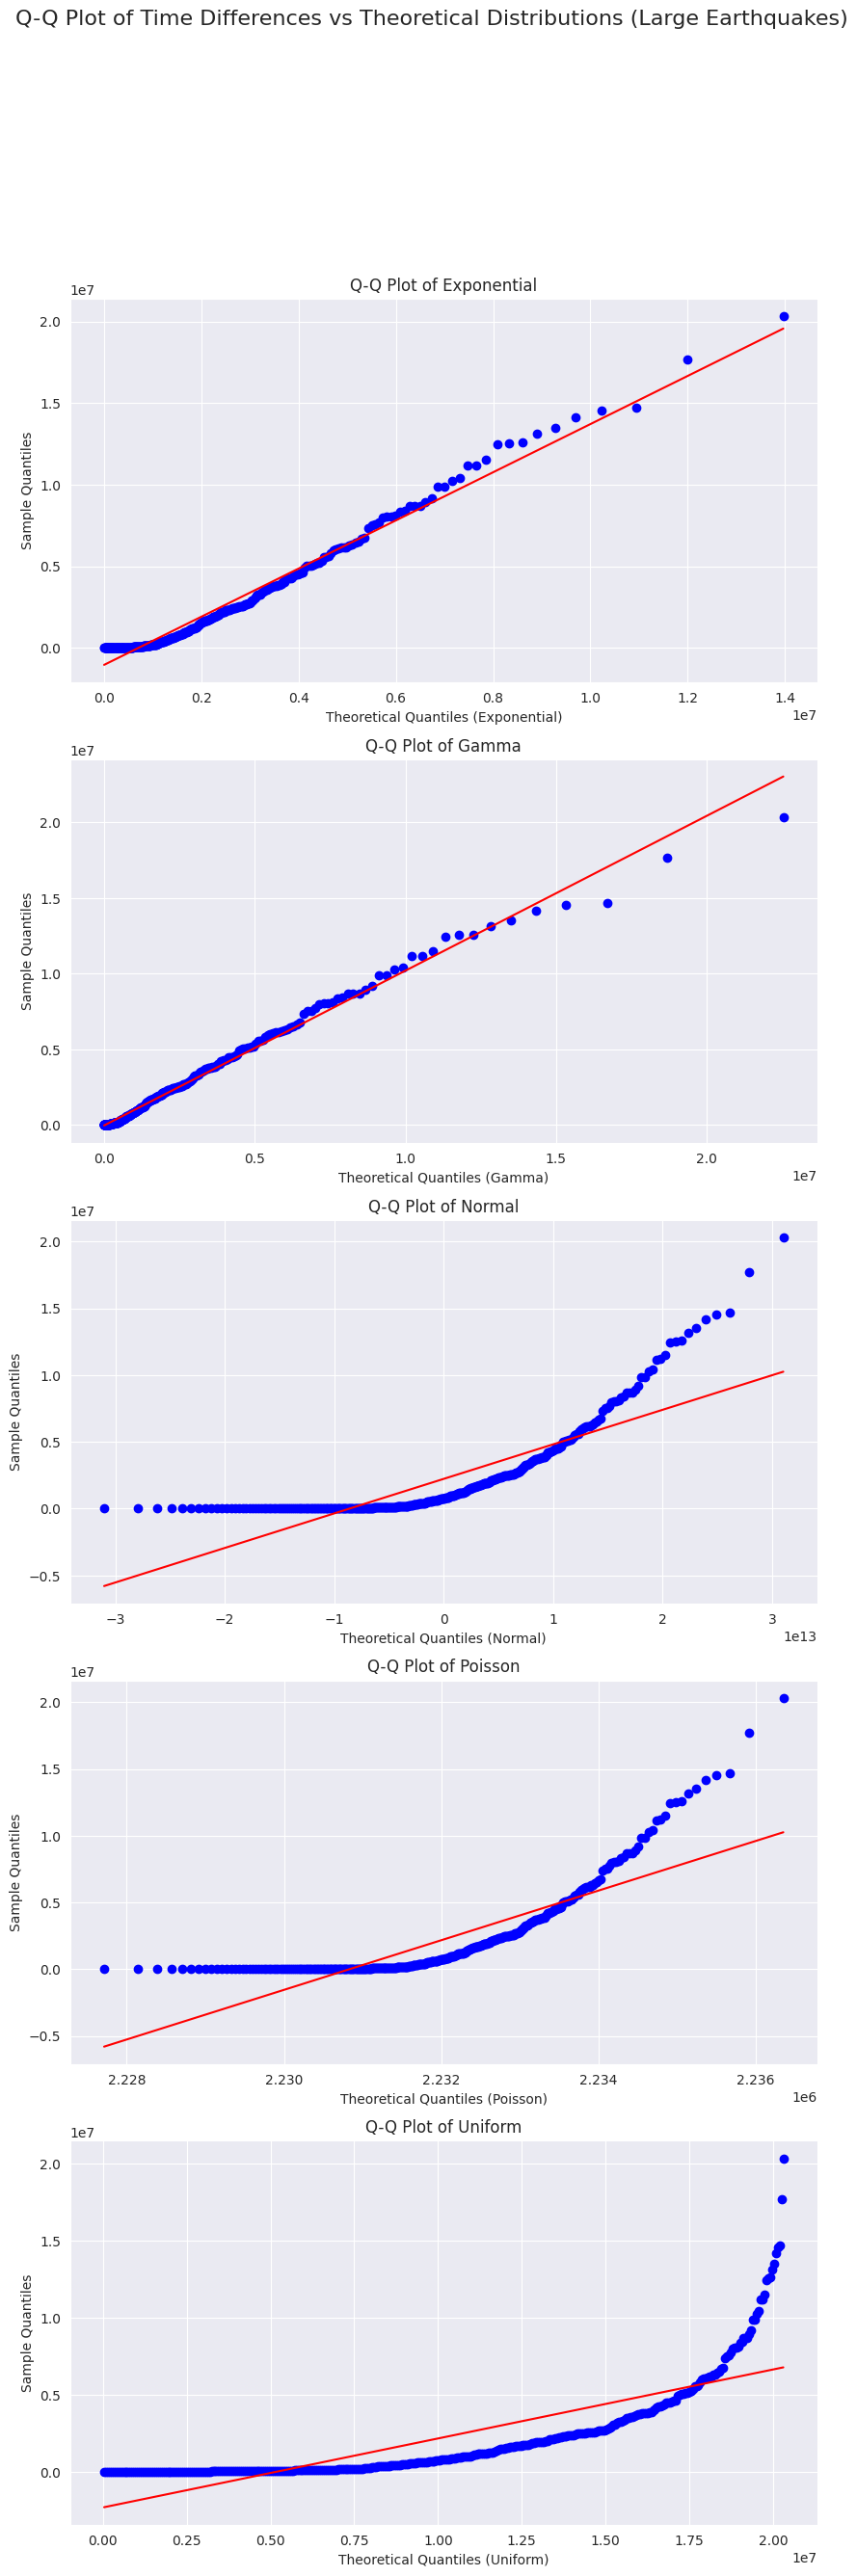

In [35]:

# Earthquakes with magnitude greater than 5
results_big_eq, params_big_eq = main(df, "Large")


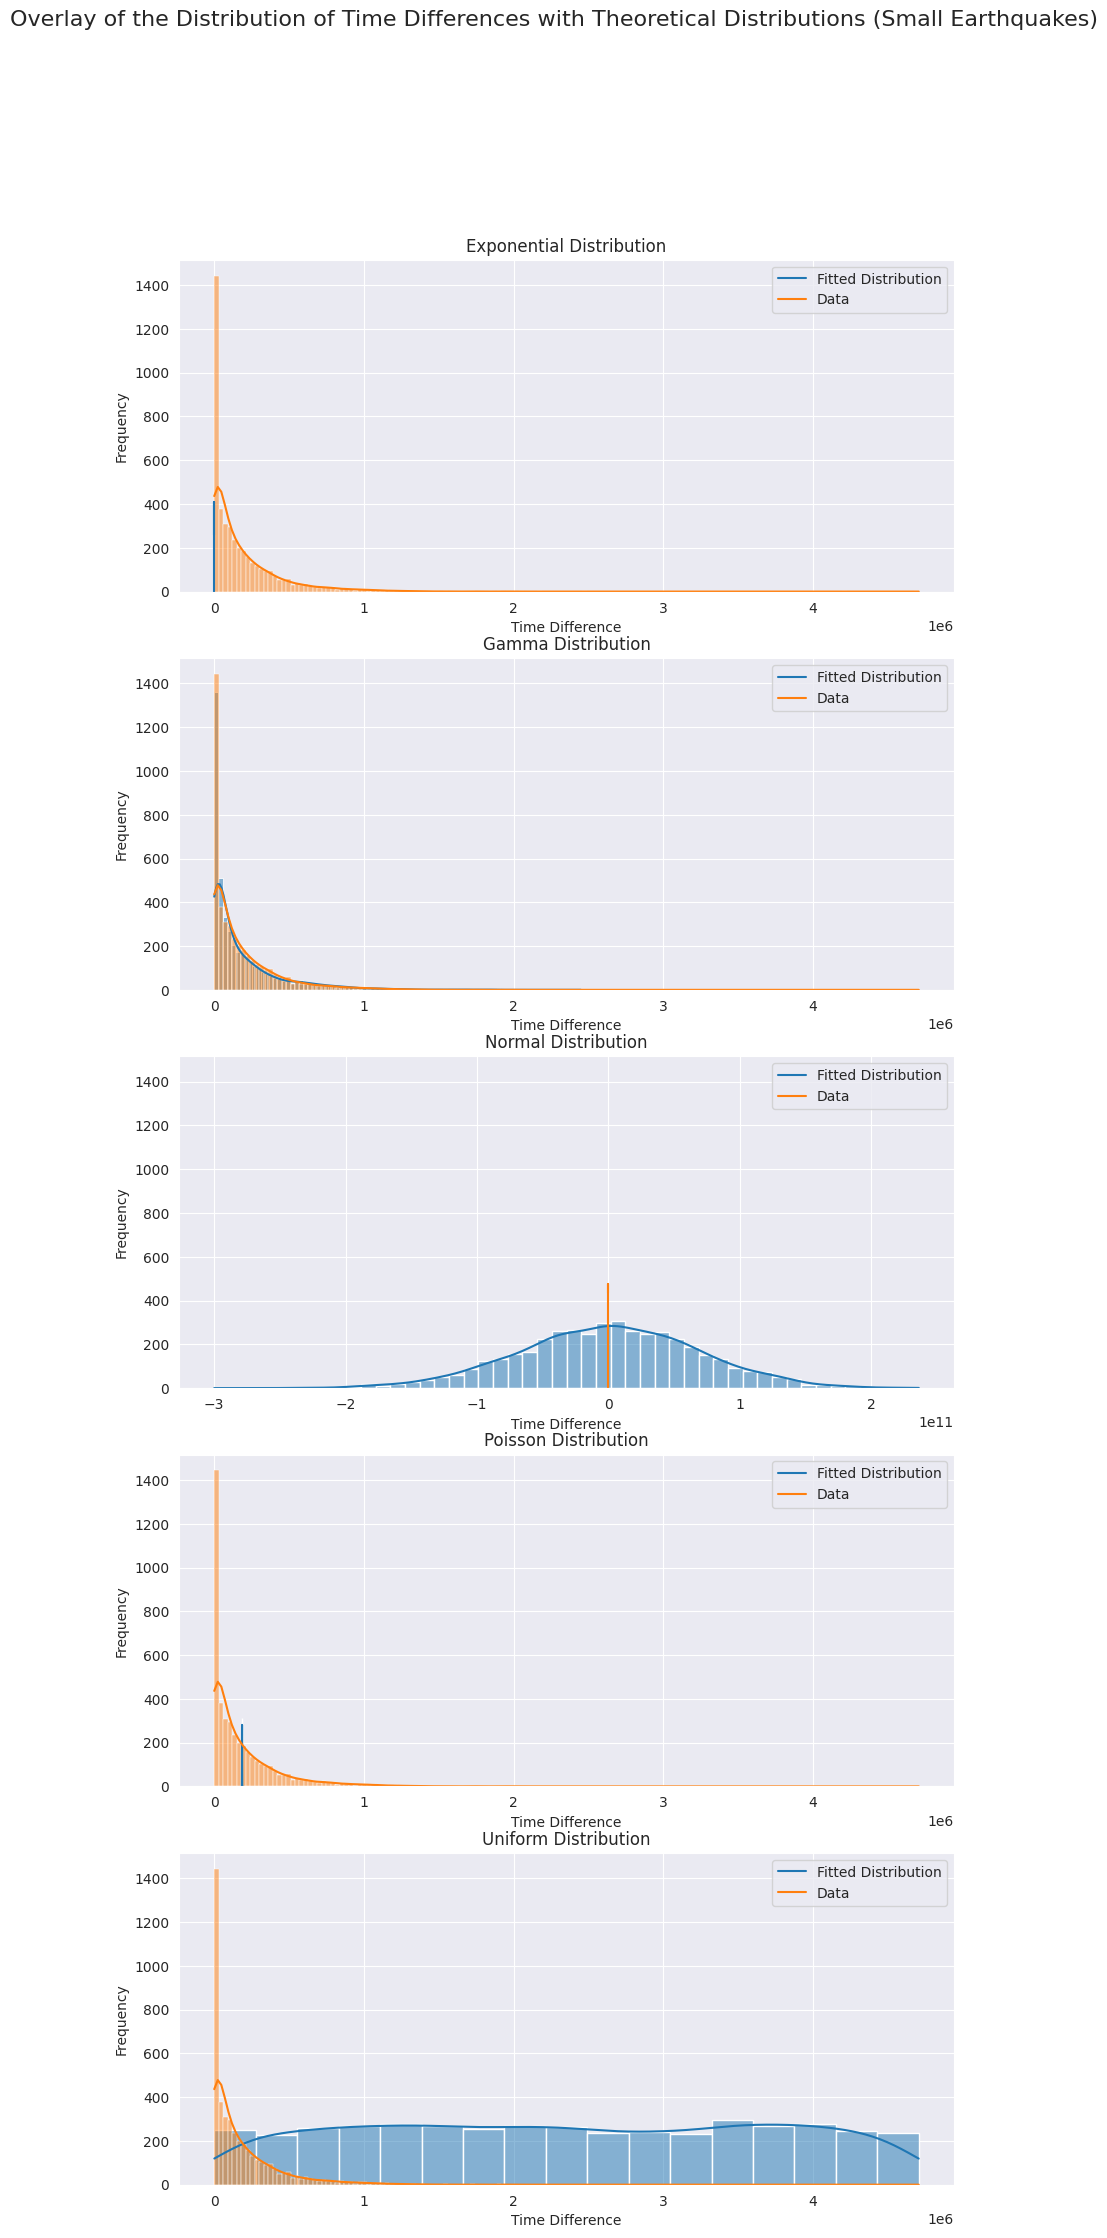

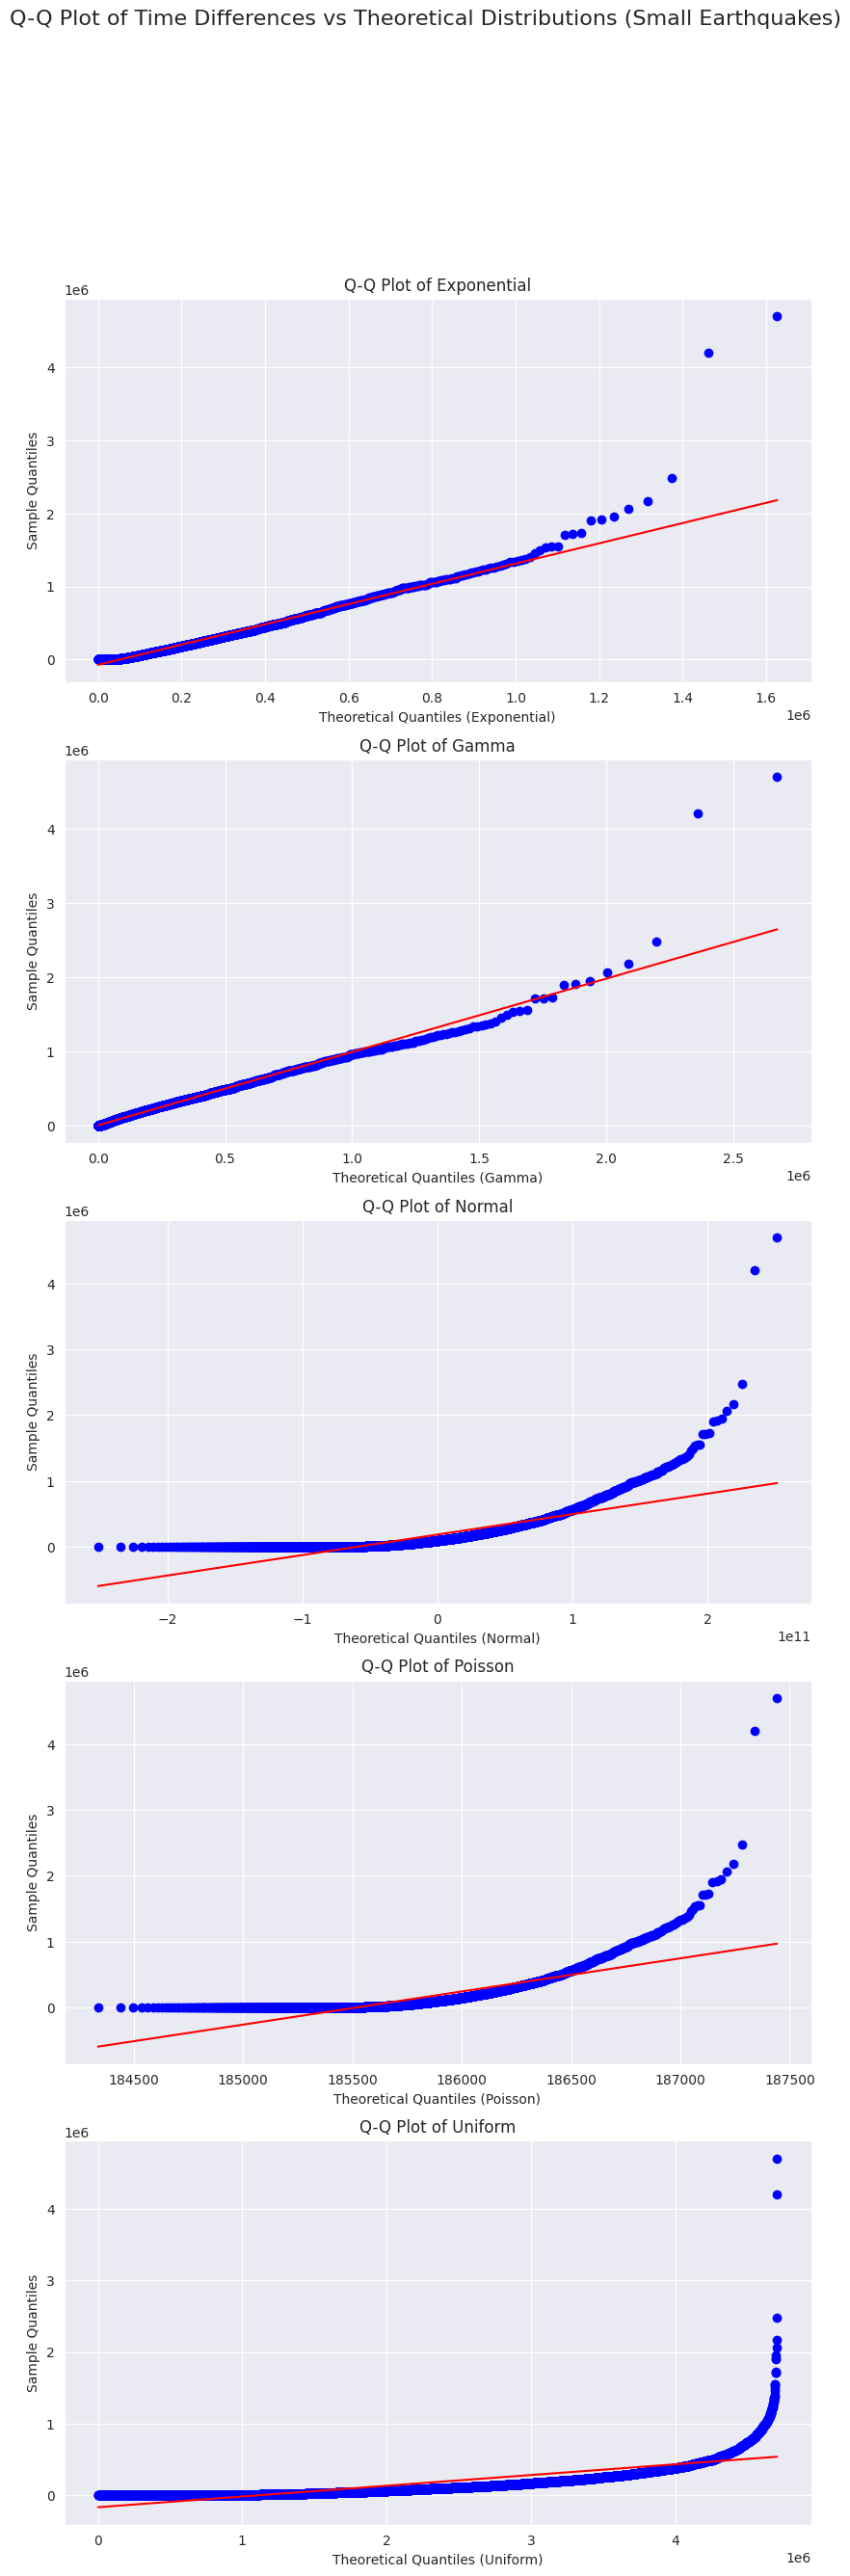

In [36]:

# Earthquakes with magnitude less than 5
results_sm_eq, params_sm_eq = main(df, "Small")



The best fit distribution for the magnitude of the earthquakes is Gamma Distribution with a p-value of 1.6806179373296966e-41
The estimated parameters are: {'estimated_alpha': np.float64(85.03819936532432), 'estimated_beta': np.float64(19.34853937538075)}
The probability of a large earthquake occurring is 0.10545929954264188


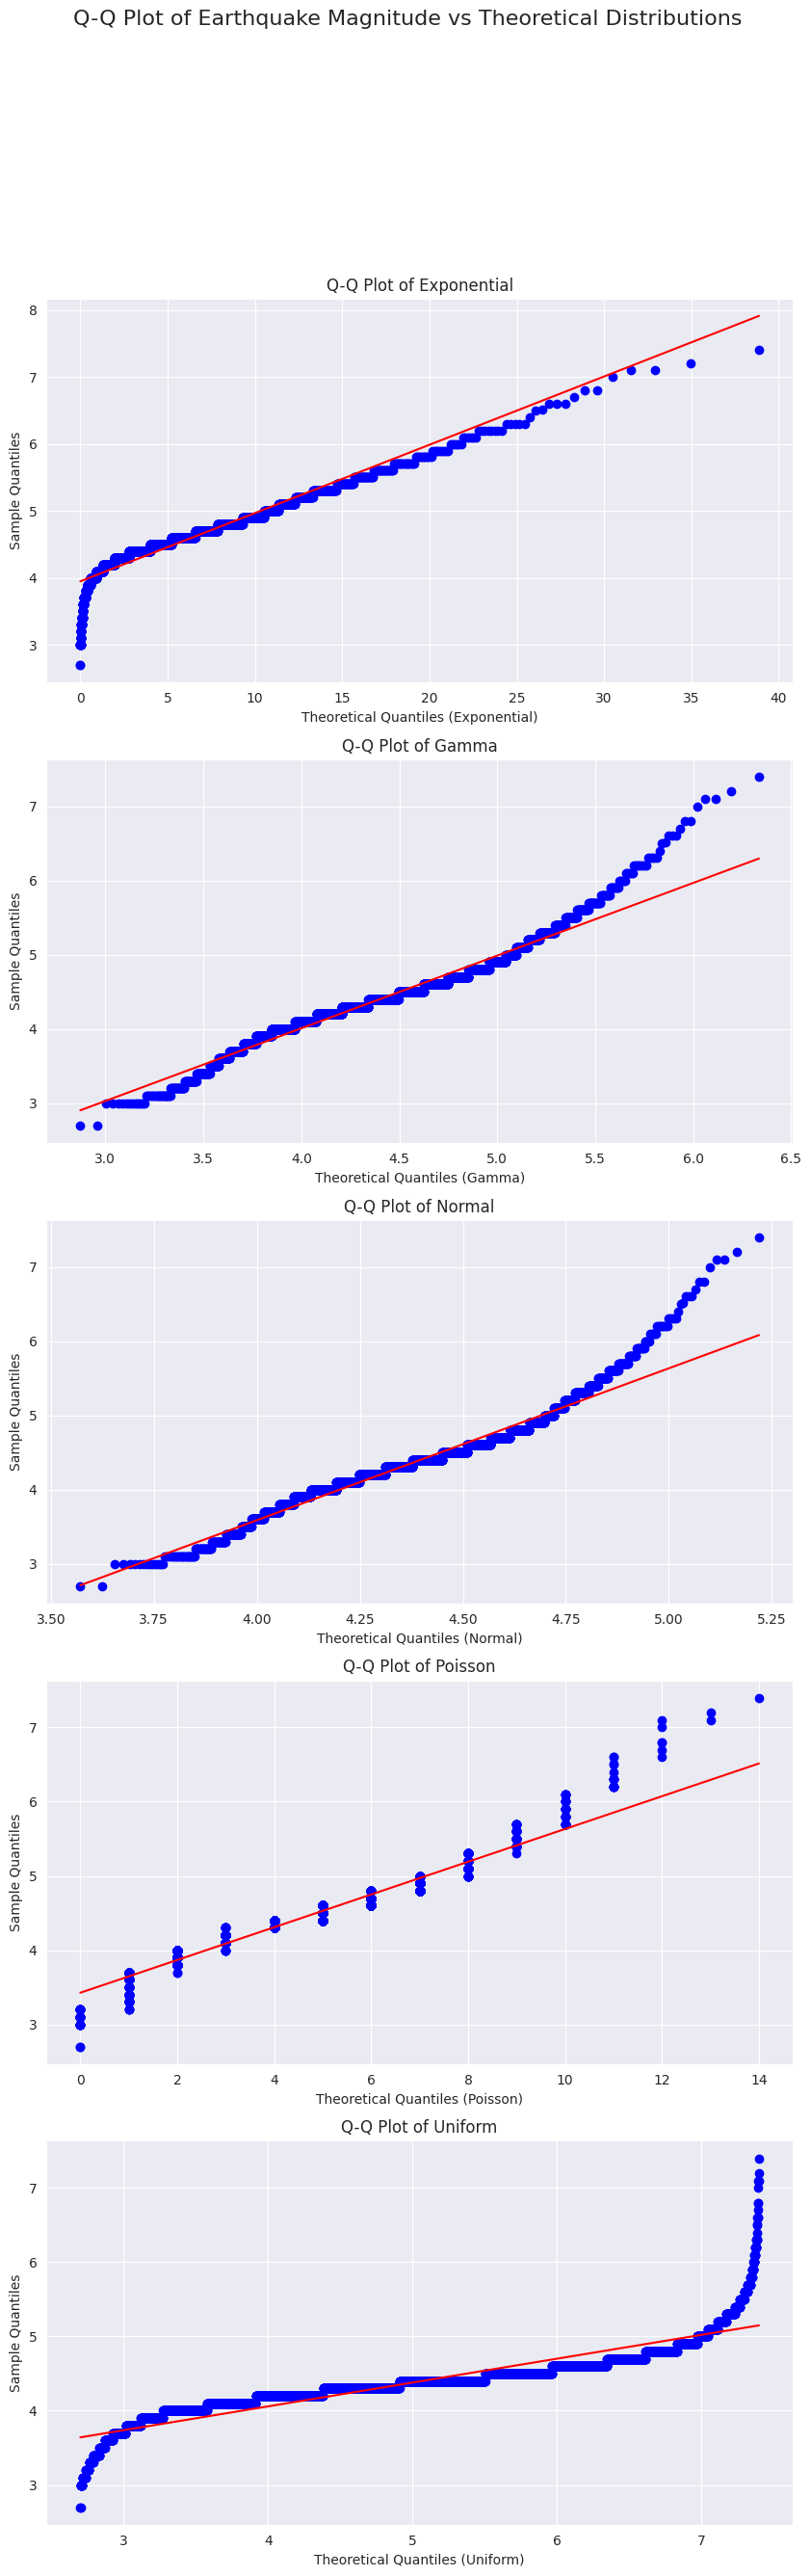

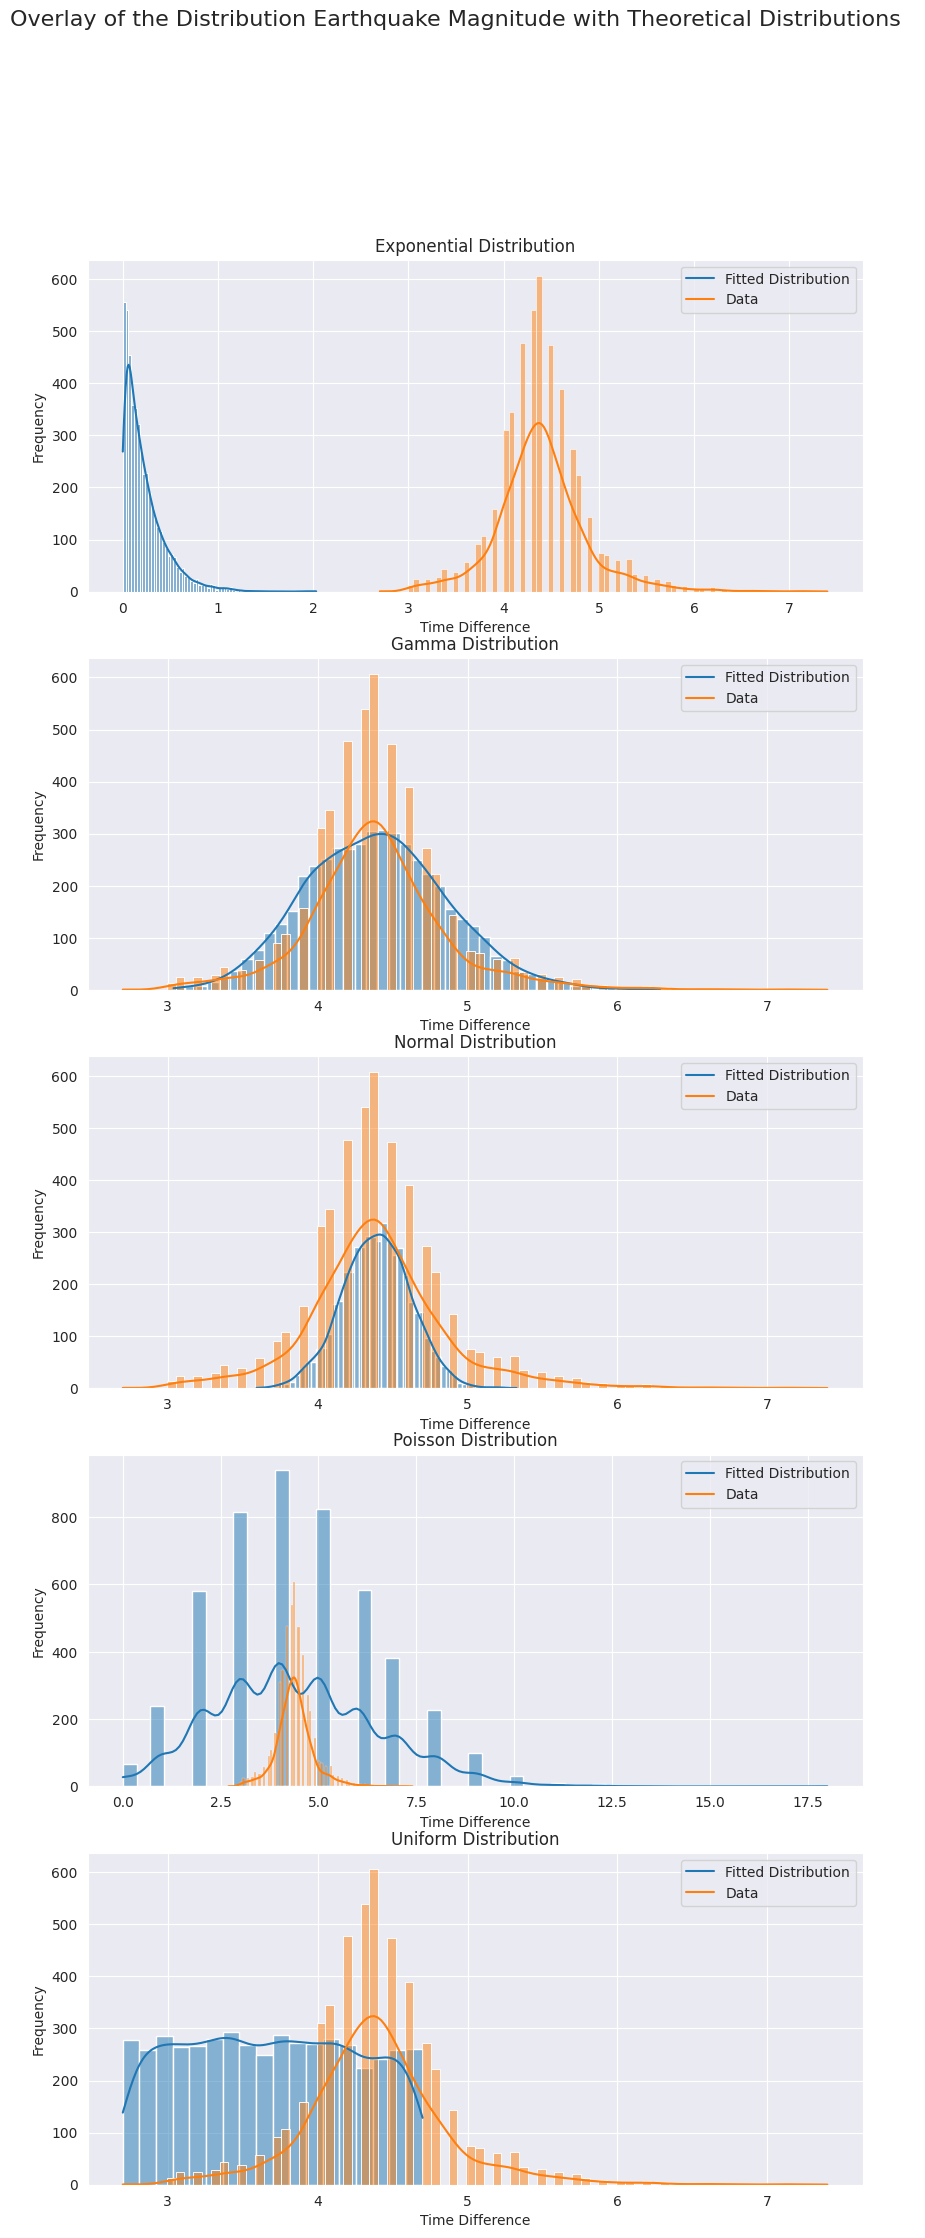

In [37]:

mag_dist_type, mag_dist_params = magnitude_analysis(df)

# Simulation

In [38]:
def pick_best_distribution(results:List[List[Any]]) -> str:
    """
    Pick the best distribution based on the goodness of fit test results.
    
    :param results: A list of lists containing the results of the goodness of fit tests.
    :return: A string representing the best distribution.
    """
    highest_p_val = np.argmax([x[2] for x in results])
    return results[highest_p_val][0]

def get_params(params:Dict[str, Dict[str, float]], dist:str) -> Dict[str, float]:
    """
    Get the parameters of the best distribution.
    
    :param params: A dictionary of output parameters for the fitted distributions.
    :param dist: A string representing the best distribution.
    :return: A dictionary of parameters for the best distribution.
    """
    return params[dist]

    

In [39]:
def m_1_sim(a, b, key):
    T = 365 * 24 * 60 * 60
    ns = random.gamma(key, a, shape=(300,))/b
    t = jnp.cumsum(ns)
    i = jnp.argmax(t > T)
    return i

@eqx.filter_jit
def m_1_experiment(a, b, keys, n_runs) -> jnp.ndarray:
    keys = random.split(keys, n_runs)
    return jax.vmap(m_1_sim, in_axes=(None, None, 0))(a, b, keys)




def m_1_sim_small_and_big_eq(small_alpha, small_beta, big_alpha, big_beta,keys, n_runs) -> Tuple[jnp.ndarray, jnp.ndarray]:
    key, subkey = random.split(keys)
    small_eq = m_1_experiment(small_alpha, small_beta, subkey, n_runs)
    key, subkey = random.split(key)
    big_eq = m_1_experiment(big_alpha, big_beta,subkey, n_runs)
    return jnp.mean(small_eq), jnp.mean(big_eq)
    
    
    
    
# @eqx.filter_jit
def m_1_batched_simulate_data(params_small, params_big, all_params, n_runs, n_exps, batch_size) -> Tuple[Array, Array, Array]:
    key = random.PRNGKey(42)
    key, subkey = random.split(key)
    sum_keys = random.split(subkey, n_exps)
    key, subkey = random.split(key)
    # all_keys = random.split(key, n_exps)
    
    results_small = []
    results_big = []
    results_sum = []
    
    for i in range(0, n_runs, batch_size):
        small, big  = jax.vmap(m_1_sim_small_and_big_eq, in_axes=(None, None, None, None, 0, None))(params_small["estimated_alpha"], params_small["estimated_beta"], params_big["estimated_alpha"], params_big["estimated_beta"], sum_keys[i:i+batch_size], n_exps)
        
        
        results_small.append(small)
        results_big.append(big)
        sum_runs = small + big
        results_sum.append(sum_runs)

    
        if i % 1000 == 0:
            print(f"Batch {i} of {n_runs} completed")
        

    return jnp.concatenate(results_small), jnp.concatenate(results_big), jnp.concatenate(results_sum)



        

    
    

In [40]:
    
        
        

        


arr_1, arr_2, arr_3 = m_1_batched_simulate_data(params_sm_eq["Gamma Distribution"], params_big_eq["Gamma Distribution"], params_all_eq["Gamma Distribution"], n_runs=n_runs, n_exps=n_exps, batch_size=5)






Batch 0 of 2000 completed
Batch 1000 of 2000 completed


In [41]:
def calculate_CI(arr: Array, alpha: float = 0.05) -> Tuple[float, float]:
    """
    Calculate the confidence interval of the data.
    
    :param arr: A numpy array of data.
    :param alpha: A float representing the significance level.
    :return: A tuple of the lower and upper bounds of the confidence interval.
    """
    n = len(arr)
    mean = jnp.mean(arr)
    std = jnp.std(arr)
    z = stats.norm.ppf(1 - alpha / 2)
    lower = mean - z * std / jnp.sqrt(n)
    upper = mean + z * std / jnp.sqrt(n)
    return lower, upper

Text(0.5, 0.98, 'Simulation Method 1 Results')

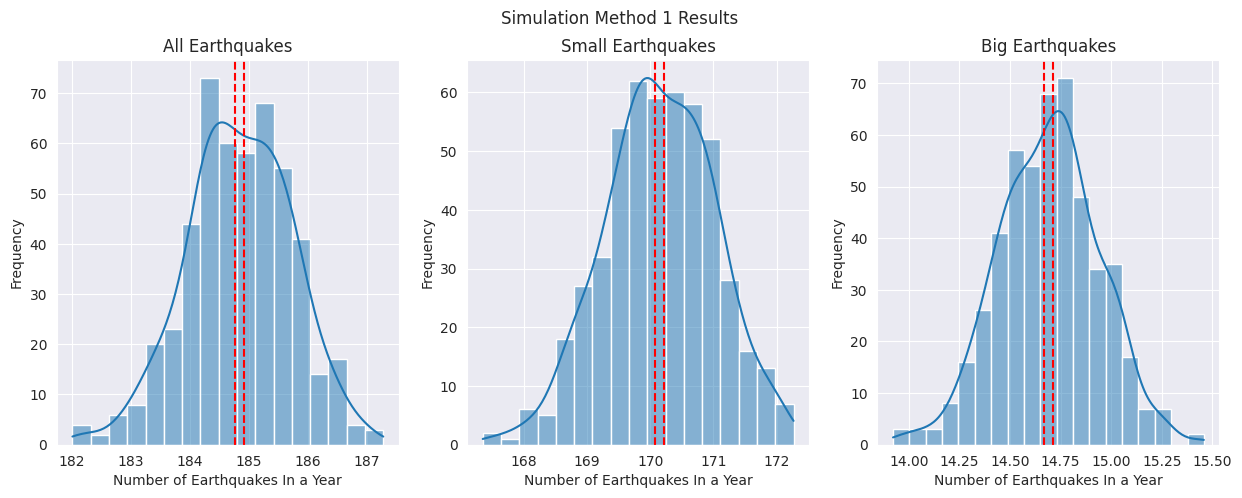

In [42]:
fig, ax = plt.subplots(nrows=1, ncols = 3, figsize=(15, 5))

sns.histplot(arr_3, kde=True, ax=ax[0])
all_CI = calculate_CI(arr_3)
ax[0].axvline(all_CI[0], color="red", linestyle="--")
ax[0].axvline(all_CI[1], color="red", linestyle="--")
ax[0].set_title("All Earthquakes")
ax[0].set_xlabel("Number of Earthquakes In a Year")
ax[0].set_ylabel("Frequency")

sns.histplot(arr_1, kde=True, ax=ax[1])
small_CI = calculate_CI(arr_1)
ax[1].axvline(small_CI[0], color="red", linestyle="--")
ax[1].axvline(small_CI[1], color="red", linestyle="--")


ax[1].set_title("Small Earthquakes")
ax[1].set_xlabel("Number of Earthquakes In a Year")
ax[1].set_ylabel("Frequency")

sns.histplot(arr_2, kde=True, ax=ax[2])
big_CI = calculate_CI(arr_2)
ax[2].axvline(big_CI[0], color="red", linestyle="--")
ax[2].axvline(big_CI[1], color="red", linestyle="--")
ax[2].set_title("Big Earthquakes")
ax[2].set_xlabel("Number of Earthquakes In a Year")
ax[2].set_ylabel("Frequency")



fig.suptitle("Simulation Method 1 Results")

In [43]:
def calculate_summary(arr: Array) -> Dict[str, float]:
    """
    Calculate the summary statistics of the data.
    
    :param arr: A numpy array of data.
    :param CI: A tuple of the lower and upper bounds of the confidence interval.
    :return: A dictionary of summary statistics.
    """
    CI = calculate_CI(arr)
    return {
        "mean": jnp.mean(arr),
        "std": jnp.std(arr),
        "CI_lower": CI[0],
        "CI_upper": CI[1]
    }

In [44]:
pprint(calculate_summary(arr_1))
pprint(calculate_summary(arr_2))
pprint(calculate_summary(arr_3))

{'CI_lower': Array(170.07315, dtype=float32),
 'CI_upper': Array(170.22488, dtype=float32),
 'mean': Array(170.14902, dtype=float32),
 'std': Array(0.86554605, dtype=float32)}
{'CI_lower': Array(14.670481, dtype=float32),
 'CI_upper': Array(14.713778, dtype=float32),
 'mean': Array(14.692129, dtype=float32),
 'std': Array(0.24697877, dtype=float32)}
{'CI_lower': Array(184.76306, dtype=float32),
 'CI_upper': Array(184.91922, dtype=float32),
 'mean': Array(184.84114, dtype=float32),
 'std': Array(0.89080137, dtype=float32)}


# Method 2


In [45]:
mag_dist_type, mag_dist_params

('Gamma Distribution',
 {'estimated_alpha': np.float64(85.03819936532432),
  'estimated_beta': np.float64(19.34853937538075)})

In [46]:
# def simulate_magnitude_data(alpha, beta, n_eqs, key) -> int:
#     """
#     Simulate earthquake magnitude data.
#     
#     :param mag_params: A dictionary of parameters for the magnitude distribution.
#     :param n_runs: An integer representing the number of runs.
#     :param n_eqs: An integer representing the number of earthquakes.
#     :param key: A PRNG key.
#     :return: Count of earthquakes simulated with magnitude less than 5.
#     """
#     key, subkey = random.split(key)
#     magnitude_data = random.gamma(subkey, alpha, shape=(n_eqs,))/beta
# 
#     return magnitude_data[magnitude_data<5].shape[0]
# 
# 
# def batched_simulate_data_and_mag(all_params, mag_params, n_exps, n_runs, batch_size) -> Tuple[Array, Array]:
#     key = random.PRNGKey(42)
# 
#     key, subkey = random.split(key)
#     all_keys = random.split(key, n_exps)
#     
#     results = []
#     small_count = []
#     
#     foo = lambda x, key: simulate_magnitude_data(mag_dist_params["estimated_alpha"], mag_dist_params["estimated_beta"], x, key)
#     
#     for i in tqdm(range(0, n_exps, batch_size)):
# 
#         all_runs = jax.vmap(experiment, in_axes=(None, None, 0, None))(all_params["estimated_alpha"], all_params["estimated_beta"], all_keys[i:i+batch_size], n_runs)
#         
#         all_small = []
#         l_key = random.split(key, n_runs)
# 
#         for run in all_runs:
#             small = [foo(x, t_key) for x,t_key in zip(run, l_key)]
#             all_small.append(small)
# 
#         
#         all_small = jnp.array(all_small)
#         small_mean = jnp.mean(all_small, axis=1)
#         all_mean = jnp.mean(all_runs, axis=1)
#         
#         results.append(all_mean)
#         small_count.append(small_mean)
#             
#             
#     return jnp.concatenate(results), jnp.array(small_count)
# 
#         



In [47]:

def simulate_magnitude_data(alpha, beta, n_eqs) -> int:
    magnitude_data = np.random.gamma(alpha, 1/beta, n_eqs)
    return np.sum(magnitude_data < 5)

def m_2_experiment(a, b, n_runs) -> np.ndarray:
    results = []
    for _ in range(n_runs):
        T = 365 * 24 * 60 * 60
        ns = np.random.gamma(a, 1/b, 300)
        t = np.cumsum(ns)
        i = np.argmax(t > T)
        results.append(i)
    return np.array(results)

def m_2_batched_simulate_data_and_mag(all_params, mag_params, n_runs, n_exps, batch_size) -> Tuple[np.ndarray, np.ndarray]:
    results = []
    small_count = []

    foo = lambda x: simulate_magnitude_data(mag_params["estimated_alpha"], mag_params["estimated_beta"], x)

    for i in tqdm(range(0, n_runs, batch_size)):
        all_runs = [m_2_experiment(all_params["estimated_alpha"], all_params["estimated_beta"], n_exps) for _ in range(batch_size)]

        all_small = []
        for run in all_runs:
            small = [foo(x) for x in run]
            all_small.append(small)

        all_small = np.array(all_small)
        small_mean = np.mean(all_small, axis=1)
        all_mean = np.mean(all_runs, axis=1)

        results.append(all_mean)
        small_count.append(small_mean)

    return np.concatenate(results), np.concatenate(small_count)



t, s = m_2_batched_simulate_data_and_mag(params_all_eq["Gamma Distribution"], mag_dist_params, n_runs, n_exps, 10)

  0%|          | 0/200 [00:00<?, ?it/s]

In [48]:
b = t - s

Text(0.5, 0.98, 'Simulation Method 2 Results')

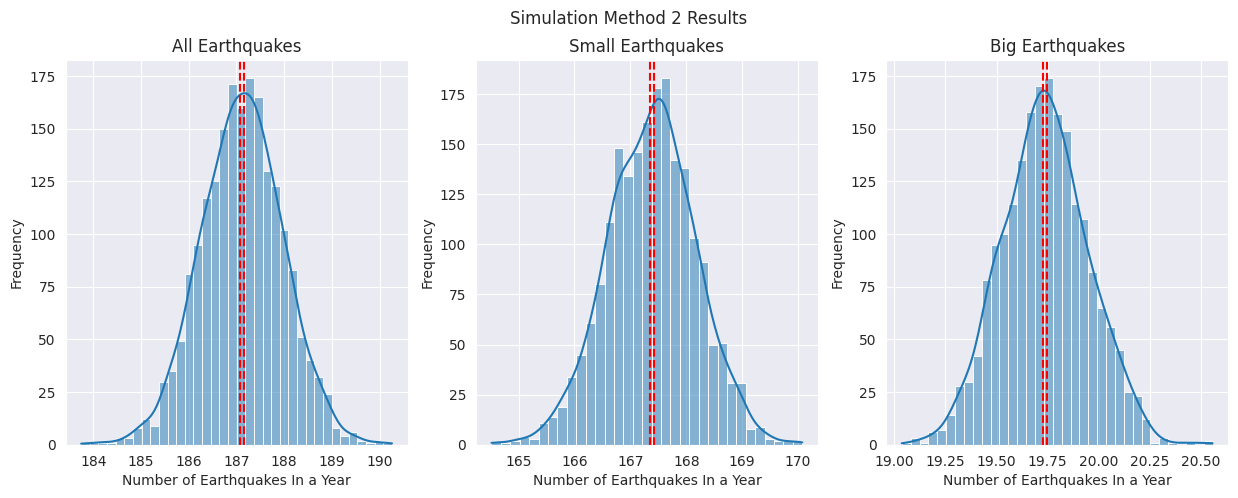

In [49]:
fig, ax = plt.subplots(nrows=1, ncols = 3, figsize=(15, 5))

sns.histplot(t, kde=True, ax=ax[0])
total_CI = calculate_CI(t)
ax[0].axvline(total_CI[0], color="red", linestyle="--")
ax[0].axvline(total_CI[1], color="red", linestyle="--")


ax[0].set_title("All Earthquakes")
ax[0].set_xlabel("Number of Earthquakes In a Year")
ax[0].set_ylabel("Frequency")
    
sns.histplot(s, kde=True, ax=ax[1])
small_CI = calculate_CI(s)
ax[1].axvline(small_CI[0], color="red", linestyle="--")
ax[1].axvline(small_CI[1], color="red", linestyle="--")
ax[1].set_title("Small Earthquakes")
ax[1].set_xlabel("Number of Earthquakes In a Year")
ax[1].set_ylabel("Frequency")

sns.histplot(b, kde=True, ax=ax[2])
big_CI = calculate_CI(b)
ax[2].axvline(big_CI[0], color="red", linestyle="--")
ax[2].axvline(big_CI[1], color="red", linestyle="--")

ax[2].set_title("Big Earthquakes")

ax[2].set_xlabel("Number of Earthquakes In a Year")
ax[2].set_ylabel("Frequency")

fig.suptitle("Simulation Method 2 Results")


In [50]:
pprint(calculate_summary(b))

{'CI_lower': Array(19.7281, dtype=float32),
 'CI_upper': Array(19.74665, dtype=float32),
 'mean': Array(19.737375, dtype=float32),
 'std': Array(0.21165086, dtype=float32)}


# Sensitivity analysis

# Method 2

In [52]:
def sample_from_actually_observed_data(data:pd.DataFrame, n_samples:int) -> pd.DataFrame:
    """
    Sample from the actually observed data.
    
    :param data: A pandas DataFrame of the observed data.
    :param n_samples: An integer representing the number of samples to draw.
    :return: A pandas DataFrame of the sampled data.
    """
    return data.sample(n_samples, replace=True)


In [53]:

def method_2_sensitivity_experiment(data: pd.DataFrame, n_exps: int) -> Tuple[float, float]:
    """
    Perform a sensitivity analysis by sampling from the observed data and simulating the number of earthquakes.

    :param data: A pandas DataFrame of the observed data.
    :param n_exps: An integer representing the number of experiments.
    :return: A tuple of the mean number of small and big earthquakes.
    """
    year_in_seconds = 365 * 24 * 60 * 60
    small_res = np.zeros(n_exps)
    big_res = np.zeros(n_exps)

    for i in range(n_exps):
        samp = sample_from_actually_observed_data(data, 210)
        cumulative_time = np.cumsum(samp["time"].values)
        mags = samp["mag"].values
        small_res[i] = np.sum(mags[cumulative_time < year_in_seconds] < 5)
        big_res[i] = np.sum(mags[cumulative_time < year_in_seconds] >= 5)

    return np.mean(small_res), np.mean(big_res)

def method_2_sensitivity_analysis(data: pd.DataFrame, n_runs: int = 1000, n_exps: int = 1000) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform a sensitivity analysis over multiple runs.

    :param data: A pandas DataFrame of the observed data.
    :param n_runs: An integer representing the number of runs.
    :param n_exps: An integer representing the number of experiments per run.
    :return: Two numpy arrays containing the results of small and big earthquakes.
    """
    data["time"] = process_time(data["time"])
    small_res = np.zeros(n_runs)
    big_res = np.zeros(n_runs)

    for i in tqdm(range(n_runs)):
        small_res[i], big_res[i] = method_2_sensitivity_experiment(data, n_exps)

    return small_res, big_res


m2_s, m2_b = method_2_sensitivity_analysis(df, n_runs=n_runs, n_exps=n_exps)

m2_t = m2_s + m2_b

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Sensitivity Analysis Method 2 Results')

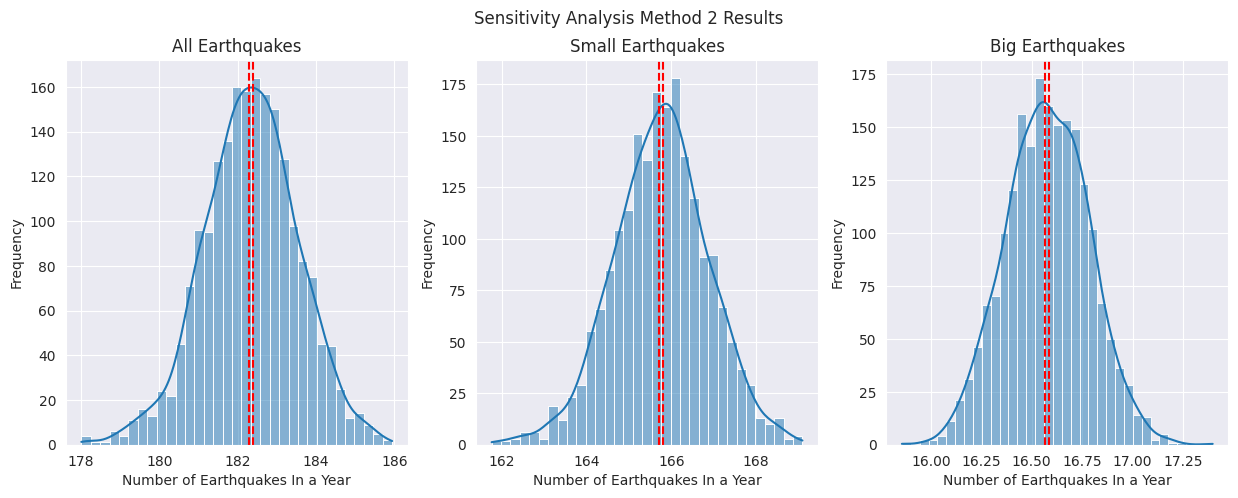

In [54]:
fig, ax = plt.subplots(nrows=1, ncols = 3, figsize=(15, 5))

sns.histplot(m2_t, kde=True, ax=ax[0])
total_CI = calculate_CI(m2_t)
ax[0].axvline(total_CI[0], color="red", linestyle="--")
ax[0].axvline(total_CI[1], color="red", linestyle="--")


ax[0].set_title("All Earthquakes")
ax[0].set_xlabel("Number of Earthquakes In a Year")
ax[0].set_ylabel("Frequency")
    
sns.histplot(m2_s, kde=True, ax=ax[1])
small_CI = calculate_CI(m2_s)
ax[1].axvline(small_CI[0], color="red", linestyle="--")
ax[1].axvline(small_CI[1], color="red", linestyle="--")
ax[1].set_title("Small Earthquakes")
ax[1].set_xlabel("Number of Earthquakes In a Year")
ax[1].set_ylabel("Frequency")

sns.histplot(m2_b, kde=True, ax=ax[2])
big_CI = calculate_CI(m2_b)
ax[2].axvline(big_CI[0], color="red", linestyle="--")
ax[2].axvline(big_CI[1], color="red", linestyle="--")

ax[2].set_title("Big Earthquakes")

ax[2].set_xlabel("Number of Earthquakes In a Year")
ax[2].set_ylabel("Frequency")

fig.suptitle("Sensitivity Analysis Method 2 Results")

## Method 1


In [ ]:
def method_1_sensitivity_experiment(df_small, df_big, n_exps):

    year_in_seconds = 365 * 24 * 60 * 60
    small_res = np.zeros(n_exps)
    big_res = np.zeros(n_exps)

    for i in range(n_exps):
        small_sample = sample_from_actually_observed_data(df_small, 210)
        big_sample = sample_from_actually_observed_data(df_big, 50)
        small_cum_time = np.cumsum(small_sample["time"].values)
        big_cum_time = np.cumsum(big_sample["time"].values)

        small_mags = small_sample["mag"].values
        big_mags = big_sample["mag"].values

        small_res[i] = np.sum(small_mags[small_cum_time < year_in_seconds])
        big_res[i] = np.sum(big_mags[big_cum_time < year_in_seconds])
    
    return np.mean(small_res), np.mean(big_res)


def method_1_sensitivity_analysis(data, n_runs=1000, n_exps=1000):
    
    df_small = data[data["mag"] < 5]
    df_big = data[data["mag"] >= 5]
    
    df_small["time"] = process_time(df_small["time"])
    df_big["time"] = process_time(df_big["time"])
    
    small_res = np.zeros(n_runs)
    big_res = np.zeros(n_runs)
    
    for i in tqdm(range(n_runs)):
        small_res[i], big_res[i] = method_1_sensitivity_experiment(df_small, df_big, n_exps)
        
    return small_res, big_res
    
    
        

    
m1_s , m1_b = method_1_sensitivity_analysis(df, n_runs=n_runs, n_exps=n_exps)
m1_t = m1_s + m1_b
    

/tmp/ipykernel_18257/598030318.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small["time"] = process_time(df_small["time"])
/tmp/ipykernel_18257/598030318.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_big["time"] = process_time(df_big["time"])


  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols = 3, figsize=(15, 5))

sns.histplot(m1_t, kde=True, ax=ax[0])
total_CI = calculate_CI(m1_t)
ax[0].axvline(total_CI[0], color="red", linestyle="--")
ax[0].axvline(total_CI[1], color="red", linestyle="--")


ax[0].set_title("All Earthquakes")
ax[0].set_xlabel("Number of Earthquakes In a Year")
ax[0].set_ylabel("Frequency")
    
sns.histplot(m1_s, kde=True, ax=ax[1])
small_CI = calculate_CI(m1_s)
ax[1].axvline(small_CI[0], color="red", linestyle="--")
ax[1].axvline(small_CI[1], color="red", linestyle="--")
ax[1].set_title("Small Earthquakes")
ax[1].set_xlabel("Number of Earthquakes In a Year")
ax[1].set_ylabel("Frequency")

sns.histplot(m1_b, kde=True, ax=ax[2])
big_CI = calculate_CI(m1_b)
ax[2].axvline(big_CI[0], color="red", linestyle="--")
ax[2].axvline(big_CI[1], color="red", linestyle="--")

ax[2].set_title("Big Earthquakes")

ax[2].set_xlabel("Number of Earthquakes In a Year")
ax[2].set_ylabel("Frequency")

fig.suptitle("Sensitivity Analysis Method 1 Results")